# Auto-Encoder para fraudes de cartão de crédito

Um banco tem o seguinte problema: dada uma transação, ele gostaria de saber se a mesma é legítima.
São dadas 284807 transações, contendo 492 fraudes entre elas.
Os dados disponíveis estão mascarados por motivo de privacidade, mas já pré-processados :)

Poderíamos usar um classificador, mas o (terrível) desbalanceamento entre as classes dificulta essa tarefa. Portanto, vamos usar um auto-codificador!

## Um pouco de teoria



In [1]:
# Importar dependências
                
import pandas as pd                                    # Dataframes, estruturas de dados fáceis de trabalhar
import numpy as np                                     # Operações sobre arrays
import matplotlib.pyplot as plt                        # Plot de dados
from sklearn.model_selection import train_test_split   # Separação de dados
from sklearn.preprocessing import StandardScaler       # Pré-processamento
from keras.models import Sequential                    # Modelagem de redes neurais
from keras.layers import Input, Dense                  # Modelagem de redes neurais

Using TensorFlow backend.


In [2]:

import types
import pandas as pd
# from botocore.client import Config
# import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
# client_xxx

# body = xxx
# add missing __iter__ method, so pandas accepts body as file-like object
# if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

body = 'creditcard.csv'
df = pd.read_csv(body)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.groupby(['Class']).count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,...,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315
1,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492


# 1. Leitura e pré-processamento dos dados

In [4]:
# Quase todos os dados foram mascarados e passaram por um processo de PCA (Principal Component Analysis)
# Com exceção de Time (hora do dia), Amount (quantia) e Class (0 = normal, 1 = fraude)


# Precisamos re-escalar os dados de tempo e quantia, para que não ofusquem os demais
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

# Observe os resultados:

df[['Time', 'Amount']].describe()

,Time,Amount
count,2.848070e+05,2.848070e+05
mean,-3.065637e-16,2.913952e-17
std,1.000002e+00,1.000002e+00
min,-1.996583e+00,-3.532294e-01
25%,-8.552120e-01,-3.308401e-01
50%,-2.131453e-01,-2.652715e-01
75%,9.372174e-01,-4.471707e-02
max,1.642058e+00,1.023622e+02


# 2. Divisão do dataset de treino x teste

In [5]:
# Vamos separar 20% dos dados para avaliar nosso modelo.
# NENHUM PASSO do treinamento pode usar os dados de teste! Isso superestimaria a capacidade do modelo!!

X_train, X_test = train_test_split(df, test_size=0.3)

# Vamos remover a classe do conjunto de treino (como se não tivéssemos esse dado!)
X_train = X_train.drop(['Class'], axis=1)

# E separamos a saída do conjunto de teste
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

# Aqui vamos ficar só com as matrizes
# X_train = X_train.values
# X_test = X_test.values
X_train.shape

(199364, 30)

In [6]:
# Nossa rede Auto Encoder tem:
# 30 inputs (veja acima o formato do vetor de entrada)

input_dim = X_train.shape[1]

# 15 nós na camada codificada

encoding_dim = 15

# 30 outputs (porque ela vai tentar reproduzir a entrada)

output_dim = input_dim

# Criação do modelo: tipo Sequential, com duas camadas totalmente conectadas (input implícito)

autoencoder = Sequential()
autoencoder.add(Dense(encoding_dim, activation="relu", input_dim=input_dim))
autoencoder.add(Dense(output_dim, activation='relu'))

# Compilação e Treino

autoencoder.compile(
    optimizer='rmsprop',       # Algoritmo de otimização. Outros: adam, sgd...
    loss='mean_squared_error', # O que queremos minimizar. Erro quadrático para não cancelar, médio sobre o vetor
)

autoencoder.fit(
    X_train, X_train, # Entra e sai a mesma coisa (conjunto de treino)
    epochs=10,        # Escolher com "bom senso" (mais != melhor)
    shuffle=True,     # Importante! Nunca fazer as operações na mesma ordem.
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
199364/199364 [==============================] - 4s 21us/step - loss: 0.7570
Epoch 2/10
199364/199364 [==============================] - 4s 21us/step - loss: 0.7092
Epoch 3/10
199364/199364 [==============================] - 4s 21us/step - loss: 0.6938
Epoch 4/10
199364/199364 [==============================] - 4s 20us/step - loss: 0.6842
Epoch 5/10
199364/199364 [==============================] - 4s 20us/step - loss: 0.6821
Epoch 6/10
199364/199364 [==============================] - 4s 21us/step - loss: 0.6811
Epoch 7/10
199364/199364 [==============================] - 4s 21us/step - loss: 0.6807
Epoch 8/10
199364/199364 [==============================] - 4s 20us/step - loss: 0.6804
Epoch 9/10
199364/199364 [==============================] - 4s 21us/step - loss: 0.6804
Epoch 10/10
199364/199364 [==============================] - 4s 21us/step - loss: 0.6803

In [8]:
# Gerar predições sobre o conjunto de teste e calcular o erro

predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

# Como avaliar? Veja abaixo as proporções de
# 1. Clientes normais que seriam investivados (mais = pior)
# 2. Fraudes que seriam pegas automaticamente (mais = melhor)

In [9]:
error_df.head()

,reconstruction_error,true_class
249104,0.323262,0
57687,0.148671,0
163020,1.319400,0
20323,0.221312,0
167767,0.168036,0


In [10]:
good_df = error_df[error_df.true_class == 0] # Tabela de erros p/ clientes normais
fraud_df = error_df[error_df.true_class == 1] # Tabela de erros p/ fraudes (bem maiores!)

fraud_df.head()

,reconstruction_error,true_class
11841,65.659991,1
154286,14.266365,1
17366,95.978940,1
233258,4.483219,1
201601,2.942873,1


In [11]:
fraud_df.describe()

,reconstruction_error,true_class
count,152.000000,152.0
mean,24.909576,1.0
std,36.010117,0.0
min,0.118051,1.0
25%,3.580075,1.0
50%,8.251815,1.0
75%,29.616370,1.0
max,232.193325,1.0


In [12]:
good_df.describe()

,reconstruction_error,true_class
count,85291.000000,85291.0
mean,0.646511,0.0
std,3.269228,0.0
min,0.033064,0.0
25%,0.195681,0.0
50%,0.330628,0.0
75%,0.543016,0.0
max,402.192829,0.0


In [13]:
good_df = error_df[error_df.true_class == 0] # Tabela de erros p/ clientes normais
fraud_df = error_df[error_df.true_class == 1] # Tabela de erros p/ fraudes (bem maiores!)

# Como escolher o threshold? Analisar curva ROC!
# Quantos clientes eu quero perturbar sem motivo?
# Quantas fraudes eu quero pegar?

threshold = 3.68 # -> Brique com esse valor e veja os resultados! O que acontece no 0?

print('Good com reconstrucao > {}'.format(threshold), len(good_df[good_df.reconstruction_error > threshold]))
print('Fracao Good:', len(good_df[good_df.reconstruction_error > threshold]) / float(len(good_df)))
print('Fraude com reconstrucao > {}'.format(threshold), len(fraud_df[fraud_df.reconstruction_error > threshold]))
print('Fracao Fraude:', len(fraud_df[fraud_df.reconstruction_error > threshold]) / float(len(fraud_df)))

Good com reconstrucao > 3.68 1502
Fracao Good: 0.01761029885919968
Fraude com reconstrucao > 3.68 113
Fracao Fraude: 0.743421052631579


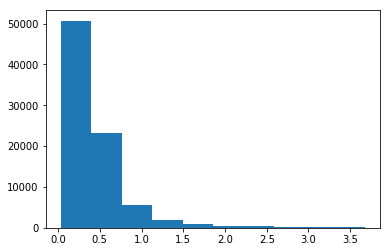

In [16]:
# Veja como estão distribuídos os erros de reconstrução para clientes normais

fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 3.68)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

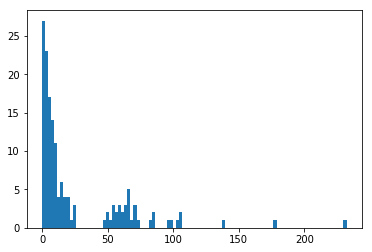

In [17]:
# E para fraudes... Muito maiores! (veja a escala do eixo horizontal)

fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=100)